In [84]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

In [85]:
df = pd.read_csv("Indicadores20221007105052.csv")
df.rename(columns={"Periodo": "period", "Valor": "value"}, inplace=True)
df

,period,value
0,1993/01,60.407691
1,1993/02,61.022521
2,1993/03,63.943249
3,1993/04,61.865984
4,1993/05,63.612900
...,...,...
350,2022/03,111.940152
351,2022/04,109.529866
352,2022/05,114.442424
353,2022/06,112.797501


In [86]:
df["log_value"] = np.log(df["value"])
df["annual_change"] = np.log(df["value"]).diff(12)
df["annual_change"].iloc[0] = np.log(df["value"].iloc[0])
df.drop(df.index[0:12], inplace=True) #values with nan's
df

,period,value,log_value,annual_change
12,1994/01,63.029268,4.143599,0.042483
13,1994/02,62.733156,4.138890,0.027647
14,1994/03,65.790275,4.186472,0.028476
15,1994/04,65.891716,4.188013,0.063042
16,1994/05,66.858802,4.202583,0.049767
...,...,...,...,...
350,2022/03,111.940152,4.717964,0.003661
351,2022/04,109.529866,4.696197,0.013414
352,2022/05,114.442424,4.740072,0.021001
353,2022/06,112.797501,4.725594,0.014522


### 1. Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable

In [87]:
af_v, af_vlog = adfuller(df["value"]), adfuller(df["log_value"]) #d=0, D=0
print(f"Value T-value: {af_v[0]}")
print(f"Value P-value: {af_v[1]}")
print(f"Log value T-value: {af_vlog[0]}")
print(f"Log value P-value: {af_vlog[1]}")

Value T-value: -1.5232968044348414
Value P-value: 0.5219568846113426
Log value T-value: -2.182176648506058
Log value P-value: 0.212777780548218


P-value de 0.52 y 0.21. Por lo tanto no se puede decir con confianza que el dataset es estacionario cuando d=0 y D=0

In [88]:
af_ac = adfuller(df["annual_change"]) #d=0, D=1
print(f"T-value: {af_ac[0]}")
print(f"P-value: {af_ac[1]}")

T-value: -3.767291622294237
P-value: 0.0032602635598127376


P-value de 0.003, se puede decir con confianza que con d=0 y D=1 el dataset se ha vuelto estacionario. Podemos proceder a p, q, P y Q.

### 2. Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.

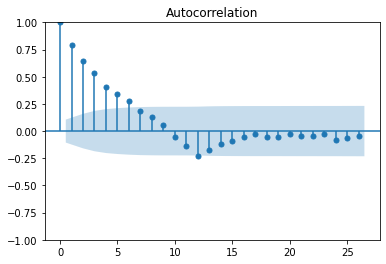

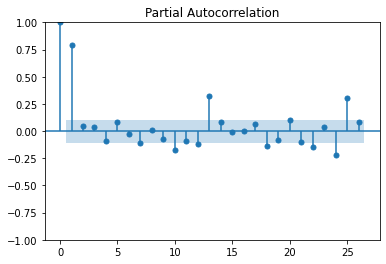

In [89]:
plot_acf(df["annual_change"]);
plot_pacf(df["annual_change"]);

El ACF muestra 6 autocorrelaciones significativas mientras que el PACF muestra solo 1 autocorrelación parcial significativa, por lo tanto, se puede apostar por un modelo con p=1 y q=0.

In [90]:
model1 = SARIMAX(df["log_value"], order=(1,0,0), seasonal_order=(0,1,0,12), simple_differencing=True).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     DS12.log_value   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 709.637
Date:                            Sun, 23 Oct 2022   AIC                          -1415.275
Time:                                    20:53:51   BIC                          -1407.670
Sample:                                         0   HQIC                         -1412.242
                                            - 331                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8194      0.022     37.343      0.000       0.776       0.862
sigma2         0.0008   2.24e-05     35.776      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):              2809.03
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

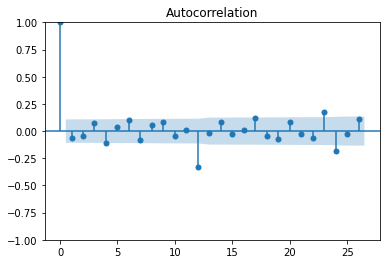

In [95]:
plot_acf(model1.resid);

Se puede ver un valor negativo en la autocorrelación 12, lo que nos indica un Q (q seasonal)

In [92]:
model2 = SARIMAX(df["log_value"], order=(1,0,0), seasonal_order=(0,1,1,12), simple_differencing=True).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       DS12.log_value   No. Observations:                  331
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 766.106
Date:                              Sun, 23 Oct 2022   AIC                          -1526.212
Time:                                      20:53:54   BIC                          -1514.806
Sample:                                           0   HQIC                         -1521.663
                                              - 331                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9810      0.014     72.554      0.000       0.955       1.008
ma.S.L12      -0.8390      0.046    -18.166      0.000      -0.929      -0.748
sigma2         0.0005   1.43e-05     38.038      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  10.60   Jarque-Bera (JB):              5301.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

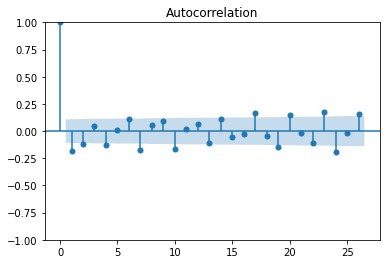

In [96]:
plot_acf(model2.resid);

Aunque se pueden ver varios puntos que apenas pasan el umbral del intervalo de confianza ya no tienen tanta correlación como el que aparecía anteriormente por lo que pueden ser omitidos sin perder bastante poder explicativo

### 3. Interpreta los coeficientes y su significancia estadística del modelo calibrado

La variable que se está analizando es el crecimiento anual en porcentaje mes a mes de la economía mexicana. La misma variable un mes anterior afectará al modelo en un 98% (entiendase como que habrá un nuevo término en el modelo final de 0.98 * varibleMesAnterior) y de forma negativa en un 83% del shock del año anterior. Se puede ver que los P-value son iguales a 0, por lo que se puede decir con confianza que las variables son estadísticamente significativas

### 4. Realiza una predicción de la variable utilizando el modelo calibrado.

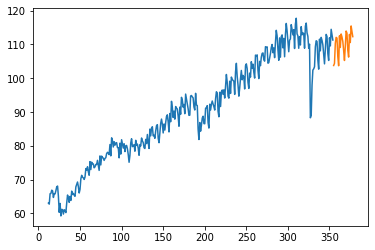

In [97]:
#return to original value
result = model2.predict(start=df["annual_change"].shape[0], end=df["annual_change"].shape[0]+24)
result = np.exp(result)
last_24_months = df["value"].tail(24)
result.reset_index(drop=True, inplace=True)
last_24_months.reset_index(drop=True, inplace=True)
result_original_value = result.add(last_24_months)

#change index for plotting
first_index = df["value"].tail(1).index.item() + 1
result_original_value.index += first_index

#plot
df["value"].plot()
result_original_value.plot()
pyplot.show()